In [1]:
!pip install sacrebleu -q
#need you again


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.8 MB/s eta 0:00:00


In [2]:
# ✅ Mô hình Transformer dịch Anh → Việt (không dùng torchtext)
#need you again

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import sacrebleu
import re
from collections import Counter

In [11]:
# === 1. Tokenizer và Vocabulary ===
def simple_tokenizer(text):
    return re.findall(r"\b\w+\b", text.lower())

def build_vocab(sentences, tokenizer, min_freq=2):
    counter = Counter()
    for sentence in sentences:
        counter.update(tokenizer(sentence))
    vocab = {"<pad>": 0, "<unk>": 1, "<bos>": 2, "<eos>": 3}
    idx = 4
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
    return vocab

def invert_vocab(vocab):
    return {idx: tok for tok, idx in vocab.items()}

In [12]:
with open("/kaggle/input/englishvietnamese-translation/en_sents", encoding="utf-8") as f:
    en_lines = f.read().splitlines()

with open("/kaggle/input/englishvietnamese-translation/vi_sents", encoding="utf-8") as f:
    vi_lines = f.read().splitlines()

df = pd.DataFrame({"en": en_lines, "vi": vi_lines}).dropna()
df = df.sample(frac=1).reset_index(drop=True)


train_df, val_df, test_df = np.split(df, [int(0.8*len(df)), int(0.9*len(df))])

SRC_VOCAB = build_vocab(train_df["en"], simple_tokenizer)
TGT_VOCAB = build_vocab(train_df["vi"], simple_tokenizer)
SRC_ITOS = invert_vocab(SRC_VOCAB)
TGT_ITOS = invert_vocab(TGT_VOCAB)

PAD_IDX = TGT_VOCAB["<pad>"]
BOS_IDX = TGT_VOCAB["<bos>"]
EOS_IDX = TGT_VOCAB["<eos>"]

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [13]:
class TranslationDataset(Dataset):
    def __init__(self, df):
        self.src = df["en"].values
        self.tgt = df["vi"].values

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        src_tok = [SRC_VOCAB.get(tok, SRC_VOCAB["<unk>"]) for tok in simple_tokenizer(self.src[idx])]
        tgt_tok = [BOS_IDX] + [TGT_VOCAB.get(tok, TGT_VOCAB["<unk>"]) for tok in simple_tokenizer(self.tgt[idx])] + [EOS_IDX]
        return torch.tensor(src_tok), torch.tensor(tgt_tok)

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_pad = nn.utils.rnn.pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_pad = nn.utils.rnn.pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_pad, tgt_pad

train_loader = DataLoader(TranslationDataset(train_df), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TranslationDataset(val_df), batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(TranslationDataset(test_df), batch_size=1)


In [3]:
# === 4. Mô hình ===
#need you again

class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512):
        super().__init__()
        self.src_embed = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt):
        src_mask = self.transformer.generate_square_subsequent_mask(src.size(0)).to(src.device)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)
        src = self.src_embed(src)
        tgt = self.tgt_embed(tgt)
        output = self.transformer(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask)
        return self.fc_out(output)

In [15]:
# === 5. Train ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = {
    "src_vocab_size": len(SRC_VOCAB),
    "tgt_vocab_size": len(TGT_VOCAB),
    "d_model": 512,
    "nhead": 8,
    "num_encoder_layers": 3,
    "num_decoder_layers": 3,
    "dim_feedforward": 512
}

model = TransformerModel(**config).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

def train_epoch():
    model.train()
    total_loss = 0
    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:-1, :]
        tgt_output = tgt[1:, :]
        optimizer.zero_grad()
        logits = model(src, tgt_input)
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:-1, :]
            tgt_output = tgt[1:, :]
            logits = model(src, tgt_input)
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))
            total_loss += loss.item()
    return total_loss / len(val_loader)
train_losses = []
val_losses = []
for epoch in range(1, 31):
    train_loss = train_epoch()
    val_loss = evaluate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Train Loss = 2.2802, Val Loss = 1.4602
Epoch 2: Train Loss = 1.4635, Val Loss = 1.2014
Epoch 3: Train Loss = 1.2630, Val Loss = 1.0857
Epoch 4: Train Loss = 1.1390, Val Loss = 1.0046
Epoch 5: Train Loss = 1.0450, Val Loss = 0.9366
Epoch 6: Train Loss = 0.9742, Val Loss = 0.9047
Epoch 7: Train Loss = 0.9216, Val Loss = 0.8460
Epoch 8: Train Loss = 0.8649, Val Loss = 0.8248
Epoch 9: Train Loss = 0.8281, Val Loss = 0.8030
Epoch 10: Train Loss = 0.7856, Val Loss = 0.7695
Epoch 11: Train Loss = 0.7594, Val Loss = 0.7661
Epoch 12: Train Loss = 0.7300, Val Loss = 0.7370
Epoch 13: Train Loss = 0.7028, Val Loss = 0.7287
Epoch 14: Train Loss = 0.6782, Val Loss = 0.7160
Epoch 15: Train Loss = 0.6576, Val Loss = 0.7071
Epoch 16: Train Loss = 0.6392, Val Loss = 0.7091
Epoch 17: Train Loss = 0.6176, Val Loss = 0.6855
Epoch 18: Train Loss = 0.6006, Val Loss = 0.6821
Epoch 19: Train Loss = 0.5822, Val Loss = 0.6749
Epoch 20: Train Loss = 0.5666, Val Loss = 0.6769
Epoch 21: Train Loss = 0.5627

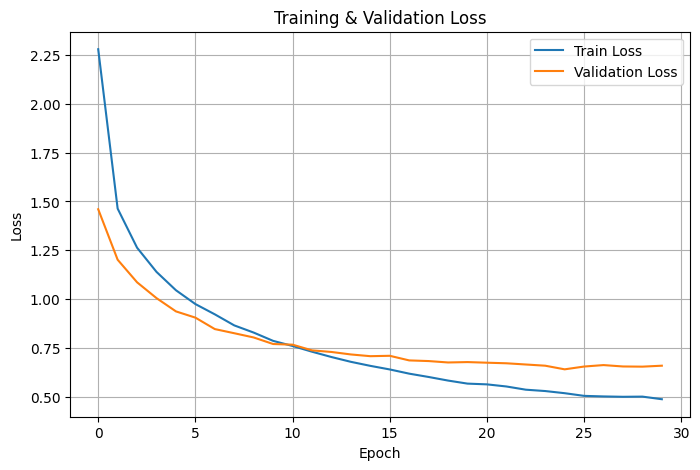

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
torch.save({
    "model_state_dict": model.state_dict(),
    "src_vocab": SRC_VOCAB,
    "tgt_vocab": TGT_VOCAB,
    "src_itos": SRC_ITOS,
    "tgt_itos": TGT_ITOS,
    "model_config": config
}, "transformer_en_vi.pth")

In [4]:
def translate(sentence):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokens = simple_tokenizer(sentence)
    src_tensor = torch.tensor(
        [SRC_VOCAB.get(tok, SRC_VOCAB["<unk>"]) for tok in tokens],
        dtype=torch.long
    ).unsqueeze(1).to(device)

    tgt_indices = [BOS_IDX]
    for _ in range(50):
        tgt_tensor = torch.tensor(tgt_indices, dtype=torch.long).unsqueeze(1).to(device)
        with torch.no_grad():
            output = model(src_tensor, tgt_tensor)
        next_token = output.argmax(2)[-1, 0].item()
        tgt_indices.append(next_token)
        if next_token == EOS_IDX:
            break

    return " ".join([TGT_ITOS[i] for i in tgt_indices[1:-1]])


In [9]:
en_sentence = "i'm a bird"
vi_translation = translate(en_sentence)

print("EN:", en_sentence)
print("VI:", vi_translation)


EN: i'm a bird
VI: tôi là một con chim


In [5]:
# === Load lại model và vocab ===
checkpoint = torch.load("/kaggle/input/kkkkkkkkkkkkkkkashi/transformer_en_vi.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")

SRC_VOCAB = checkpoint["src_vocab"]
TGT_VOCAB = checkpoint["tgt_vocab"]
SRC_ITOS = checkpoint["src_itos"]
TGT_ITOS = checkpoint["tgt_itos"]
config = checkpoint["model_config"]

PAD_IDX = TGT_VOCAB["<pad>"]
BOS_IDX = TGT_VOCAB["<bos>"]
EOS_IDX = TGT_VOCAB["<eos>"]

# === Khởi tạo lại mô hình ===
model = TransformerModel(**config).to("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TransformerModel(
  (src_embed): Embedding(12156, 512)
  (tgt_embed): Embedding(4467, 512)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-

In [7]:
import re
def simple_tokenizer(text):
    return re.findall(r"\b\w+\b", text.lower())


100%|██████████| 25409/25409 [20:22<00:00, 20.79it/s]


BLEU    : 0.5028
METEOR  : 0.7538
ROUGE-L : 0.8220
ChrF    : 0.7088


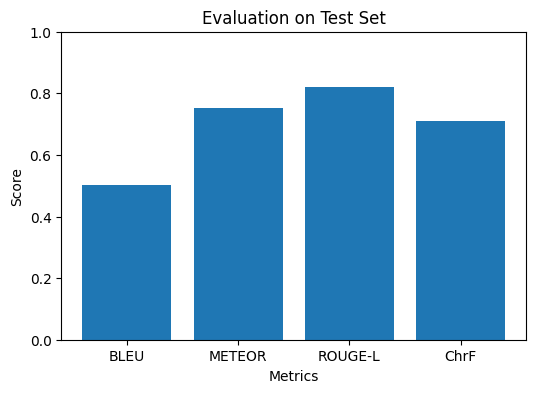

In [22]:

# ## Evaluation on Test Set (BLEU / METEOR / ROUGE-L / ChrF)
# Giữ nguyên toàn bộ notebook cũ. Phần này chỉ thêm ở cuối để đánh giá trên test_df.

# Cài/thêm thư viện nếu thiếu
try:
    from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
    from nltk.translate.meteor_score import meteor_score
except Exception as e:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "nltk"])
    from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
    from nltk.translate.meteor_score import meteor_score

try:
    from rouge_score import rouge_scorer
except Exception as e:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "rouge-score"])
    from rouge_score import rouge_scorer

try:
    from sacrebleu.metrics import CHRF
except Exception as e:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "sacrebleu"])
    from sacrebleu.metrics import CHRF

import nltk
try:
    nltk.data.find("corpora/wordnet")
except LookupError:
    nltk.download("wordnet", quiet=True)
try:
    nltk.data.find("punkt")
except LookupError:
    nltk.download("punkt", quiet=True)

import matplotlib.pyplot as plt

# BẢO ĐẢM: có model đã train và hàm translate(sentence) đã định nghĩa ở trên.
model.eval()

# Tạo predictions từ tiếng Anh sang tiếng Việt cho toàn bộ test_df
from tqdm import tqdm
predictions = []
references = []
for en_sentence, vi_ref in tqdm(zip(test_df['en'].tolist(), test_df['vi'].tolist()), total=len(test_df)):
    try:
        vi_pred = translate(en_sentence)  # dùng đúng hàm translate đã có
    except Exception as e:
        # Nếu có lỗi bất ngờ, vẫn thêm chuỗi rỗng để không vỡ vòng lặp
        vi_pred = ""
    predictions.append(vi_pred)
    references.append(vi_ref)

# Cắt đồng bộ đề phòng mismatch (thường là không cần)
n = min(len(predictions), len(references))
predictions = predictions[:n]
references = references[:n]

# ----- TÍNH CÁC CHỈ SỐ -----
# BLEU (0..1) với smoothing để tránh 0 khi câu ngắn
refs_tok = [[ref.split()] for ref in references]
hyps_tok = [pred.split() for pred in predictions]
smooth = SmoothingFunction().method3
bleu_val = corpus_bleu(refs_tok, hyps_tok, smoothing_function=smooth)

# METEOR (trung bình trên từng câu)
# METEOR (trung bình trên từng câu, cần token hóa)
meteor_vals = [
    meteor_score([ref.split()], hyp.split())
    for ref, hyp in zip(references, predictions)
]
meteor_val = sum(meteor_vals) / len(meteor_vals) if meteor_vals else 0.0


# ROUGE-L (F1 trung bình)
rouge = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
rougeL_vals = [rouge.score(ref, hyp)["rougeL"].fmeasure for ref, hyp in zip(references, predictions)]
rougeL_val = sum(rougeL_vals) / len(rougeL_vals) if rougeL_vals else 0.0

# ChrF (sacrebleu trả về %)
chrf = CHRF()
chrf_val = chrf.corpus_score(predictions, [references]).score / 100.0

print(f"BLEU    : {bleu_val:.4f}")
print(f"METEOR  : {meteor_val:.4f}")
print(f"ROUGE-L : {rougeL_val:.4f}")
print(f"ChrF    : {chrf_val:.4f}")

# ----- VẼ BIỂU ĐỒ -----
metrics = ["BLEU", "METEOR", "ROUGE-L", "ChrF"]
values = [bleu_val, meteor_val, rougeL_val, chrf_val]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values)
plt.title("Evaluation on Test Set")
plt.ylim(0, 1)
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.show()
